**Começamos abrindo o diretório no Drive onde vamos trabalhar. Em seguida, importamos os módulos que serão utilizados**

In [ ]:
!mkdir -p "drive/MyDrive/Colab Notebooks/vacinação"

In [ ]:
import urllib.request
import pandas as pd
import requests
from bs4 import BeautifulSoup
from os import remove
from datetime import date, timedelta

**Em seguida, fazemos um scrapping para baixar os dados de algum estado**
Selecione o número do estado desejado na primeira linha desta célula, de acordo com a referência na imagem. Neste exemplo, selecionamos o estado de Alagoas
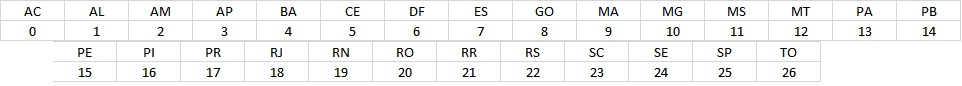

In [ ]:
#Selecione o estado desejado
uf = 1

#buscando a página que tem as url's com os csv's dos registros de vacinação
url = 'https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8'
page = requests.get(url)

#fazendo webscrapping para retornar as url's
soup = BeautifulSoup(page.content, 'html.parser')
a = soup.find_all('a', href = True)

#criando lista vazia e colocando as url's dentro dela. Depois, eliminando elementos indesejados da lista
urls = []
for i in a:
    urls.append(i['href'])
urls = urls[14:51]
url = urls[uf]
del(a, page, urls)

In [ ]:
#Fazendo download do arquivo
!wget -O "drive/MyDrive/Colab Notebooks/vacinação/buscarvacinados.csv" echo $url

--2021-06-18 11:37:05--  http://echo/
Resolving echo (echo)... failed: Name or service not known.
wget: unable to resolve host address ‘echo’
--2021-06-18 11:37:05--  https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-06-17/uf%3DAL/part-00000-d3517aef-a894-449a-bb40-fc6f03d9b051.c000.csv
Resolving s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)... 52.95.163.80
Connecting to s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)|52.95.163.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628523966 (599M) [text/csv]
Saving to: ‘drive/MyDrive/Colab Notebooks/vacinação/buscarvacinados.csv’

drive/MyDrive/Colab 100%[===================>] 599.41M  17.1MB/s    in 38s     

2021-06-18 11:37:44 (15.7 MB/s) - ‘drive/MyDrive/Colab Notebooks/vacinação/buscarvacinados.csv’ saved [628523966/628523966]

FINISHED --2021-06-18 11:37:44--
Total wall clock time: 39s
Downloaded: 1 files, 599M in 38s (15.7 MB/s)


In [ ]:
#Criando Funções de tratamento de dados mais tarde no script
def add_fxet(idade):
  if idade < 40:
    fxet = 'Menos de 40 anos'
  elif idade >= 40 and idade < 50:
    fxet = '40 - 50'
  elif idade >= 50 and idade < 60:
    fxet = '50 - 60'
  elif idade >= 60 and idade < 70:
    fxet = '60 - 70'
  elif idade >= 70 and idade < 80:
    fxet = '70 - 80'
  elif idade >= 80:
    fxet = 'Mais de 80 anos'
  return fxet

#Aqui colocamos as datas para definir o atraso na aplicação da 2ª Dose
#Estimamos 120 dias para a vacina Astrazeneca, e 45 dias para a CoronaVac e a Pfizer
dateAZ = date.today() - timedelta(days=120)
dateAZ = pd.to_datetime(dateAZ, format='%Y-%m-%d')
dateCV = date.today() - timedelta(days=45)
dateCV = pd.to_datetime(dateCV, format='%Y-%m-%d')

def latevax(data, fabricante, dose):
  if fabricante == "Astrazeneca"  and dose == 1:
    valor = 1
  elif fabricante == "Astrazeneca"  and dose == 8:
    valor = 8
  elif fabricante == "Astrazeneca" and dose == 0 and data > dateAZ:
    valor = 9
  elif fabricante == "Astrazeneca" and dose == 0 and data <= dateAZ:
    valor = 0
  elif fabricante == "CoronaVac"  and dose == 1:
    valor = 1
  elif fabricante == "CoronaVac"  and dose == 8:
    valor = 8
  elif fabricante == "CoronaVac" and dose == 0 and data > dateCV:
    valor = 9
  elif fabricante == "CoronaVac" and dose == 0 and data <= dateCV:
    valor = 0
  elif fabricante == "Pfizer"  and dose == 1:
    valor = 1
  elif fabricante == "Pfizer"  and dose == 8:
    valor = 8
  elif fabricante == "Pfizer" and dose == 0 and data > dateCV:
    valor = 9
  elif fabricante == "Pfizer" and dose == 0 and data <= dateCV:
    valor = 0
  return valor

**Agora o arquivo será lido. Como ele é grande, pode levar um bom tempo, especialmente em estados mais populosos**


In [ ]:
#criando df vazio e lendo o arquivo nele
AZ1 = pd.DataFrame()
AZ2 = pd.DataFrame()
CV1 = pd.DataFrame()
CV2 = pd.DataFrame()
PF1 = pd.DataFrame()
PF2 = pd.DataFrame()

for chunk in pd.read_csv('drive/MyDrive/Colab Notebooks/vacinação/buscarvacinados.csv', sep = ';', encoding = 'utf-8', chunksize = 100000):
    chunk['FxEt'] = list(map(add_fxet, chunk['paciente_idade']))
    chunk['vacina_dataaplicacao'] = pd.to_datetime(chunk["vacina_dataaplicacao"], format='%Y-%m-%d')
    AZ1 = AZ1.append(chunk.query("vacina_fabricante_nome == 'FUNDACAO OSWALDO CRUZ' | vacina_fabricante_nome == 'Covid-19-AstraZeneca' | vacina_fabricante_nome == 'Covid-19-Covishield-Oxford/Fiocruz' | vacina_fabricante_nome == 'SERUM INSTITUTE OF INDIA LTD'"))
    CV1 = CV1.append(chunk.query("vacina_fabricante_nome == 'FUNDACAO BUTANTAN' | vacina_fabricante_nome == 'SINOVAC LIFE SCIENCE CO LTD' | vacina_fabricante_nome == 'MINISTERIO DA SAUDE'"))
    PF1 = PF1.append(chunk.query("vacina_fabricante_nome == 'COVID-19-Pfizer (Comirnaty)'"))

AZ1 = AZ1[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
           'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao', 'vacina_fabricante_nome']]
AZ1['vacina_fabricante_nome'] = 'Astrazeneca'

CV1 = CV1[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
           'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao', 'vacina_fabricante_nome']]
CV1['vacina_fabricante_nome'] = 'CoronaVac'

PF1 = PF1[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
           'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao', 'vacina_fabricante_nome']]
PF1['vacina_fabricante_nome'] = 'Pfizer'

**Aqui separamos a base em 1ª e 2ª dose. Os números totais são imprimidos na tela para conferência**

In [ ]:
AZ2 = AZ1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa02ª\xa0Dose'").drop_duplicates('paciente_id')
CV2 = CV1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa02ª\xa0Dose'").drop_duplicates('paciente_id')
PF2 = PF1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa02ª\xa0Dose'").drop_duplicates('paciente_id')
AZ1 = AZ1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa01ª\xa0Dose'").drop_duplicates('paciente_id')
CV1 = CV1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa01ª\xa0Dose'").drop_duplicates('paciente_id')
PF1 = PF1.query("vacina_descricao_dose == '\xa0\xa0\xa0\xa01ª\xa0Dose'").drop_duplicates('paciente_id')

print(len(CV2))
print(len(AZ2))
print(len(PF2))
print(len(CV1))
print(len(AZ1))
print(len(PF1))


267026
39627
0
434019
412098
1160


In [ ]:
#Buscando os valores das 2ª's doses que não tem correspondência com 1ª's doses
CV = CV1.merge(CV2, suffixes=("", "_2"), how='outer', on='paciente_id')
CV.loc[CV['vacina_descricao_dose'].isnull(), ['FxEt']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['FxEt_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['paciente_enumsexobiologico']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['paciente_enumsexobiologico_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['paciente_racacor_valor']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['paciente_racacor_valor_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_codigo']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_codigo_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['vacina_grupoatendimento_nome']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['vacina_grupoatendimento_nome_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_nome']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_nome_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['vacina_fabricante_nome']] = CV.loc[CV['vacina_descricao_dose'].isnull()]['vacina_fabricante_nome_2']
CV.loc[CV['vacina_descricao_dose'].isnull(), ['vacina_dataaplicacao']] = 0

PF = PF1.merge(PF2, suffixes=("", "_2"), how='outer', on='paciente_id')
PF.loc[PF['vacina_descricao_dose'].isnull(), ['FxEt']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['FxEt_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['paciente_enumsexobiologico']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['paciente_enumsexobiologico_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['paciente_racacor_valor']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['paciente_racacor_valor_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_codigo']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_codigo_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['vacina_grupoatendimento_nome']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['vacina_grupoatendimento_nome_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_nome']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_nome_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['vacina_fabricante_nome']] = PF.loc[PF['vacina_descricao_dose'].isnull()]['vacina_fabricante_nome_2']
PF.loc[PF['vacina_descricao_dose'].isnull(), ['vacina_dataaplicacao']] = 0

AZ = AZ1.merge(AZ2, suffixes=("", "_2"), how='outer', on='paciente_id')
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['FxEt']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['FxEt_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['paciente_enumsexobiologico']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['paciente_enumsexobiologico_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['paciente_racacor_valor']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['paciente_racacor_valor_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_codigo']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_codigo_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['vacina_grupoatendimento_nome']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['vacina_grupoatendimento_nome_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['estabelecimento_municipio_nome']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['estabelecimento_municipio_nome_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['vacina_fabricante_nome']] = AZ.loc[AZ['vacina_descricao_dose'].isnull()]['vacina_fabricante_nome_2']
AZ.loc[AZ['vacina_descricao_dose'].isnull(), ['vacina_dataaplicacao']] = 0


**Ultimos tratamentos e agrupamento dos dados. Segue o Dicionário da coluna "vacina_descricao_dose_2":**

---
**0** : *Indivíduos com segunda dose atrasada*

**1** : *Indivíduos com segunda dose já aplicada*

**8** : *Indivíduos com segunda dose já aplicada, porém sem correspondência de primeira dose na base*

**9** : *Indivíduos no intervalo entre doses*


In [ ]:
CV = CV[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
         'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao', 
         'vacina_descricao_dose_2', 'vacina_fabricante_nome']]
CV['vacina_descricao_dose_2'] = CV['vacina_descricao_dose_2'].replace('\xa0\xa0\xa0\xa02ª\xa0Dose', 1)
CV['vacina_descricao_dose_2'] = CV['vacina_descricao_dose_2'].fillna(0)
CV.loc[CV['vacina_descricao_dose'].isnull()] = CV.loc[CV['vacina_descricao_dose'].isnull()].replace(1.0, 8)
CV['vacina_grupoatendimento_nome'] = CV['vacina_grupoatendimento_nome'].fillna("Não Especificado")
CV['vacina_descricao_dose_2'] = list(map(latevax, CV['vacina_dataaplicacao'], CV['vacina_fabricante_nome'], CV['vacina_descricao_dose_2']))

PF = PF[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
         'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao', 
         'vacina_descricao_dose_2', 'vacina_fabricante_nome']]
PF['vacina_descricao_dose_2'] = PF['vacina_descricao_dose_2'].replace('\xa0\xa0\xa0\xa02ª\xa0Dose', 1)
PF['vacina_descricao_dose_2'] = PF['vacina_descricao_dose_2'].fillna(0)
PF.loc[PF['vacina_descricao_dose'].isnull()] = PF.loc[PF['vacina_descricao_dose'].isnull()].replace(1.0, 8)
PF['vacina_grupoatendimento_nome'] = PF['vacina_grupoatendimento_nome'].fillna("Não Especificado")
PF['vacina_descricao_dose_2'] = list(map(latevax, PF['vacina_dataaplicacao'], PF['vacina_fabricante_nome'], PF['vacina_descricao_dose_2']))

AZ = AZ[['paciente_id', 'FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo',
         'vacina_grupoatendimento_nome', 'vacina_descricao_dose', 'estabelecimento_municipio_nome', 'vacina_dataaplicacao',
         'vacina_descricao_dose_2', 'vacina_fabricante_nome']]
AZ['vacina_descricao_dose_2'] = AZ['vacina_descricao_dose_2'].replace('\xa0\xa0\xa0\xa02ª\xa0Dose', 1)
AZ['vacina_descricao_dose_2'] = AZ['vacina_descricao_dose_2'].fillna(0)
AZ.loc[AZ['vacina_descricao_dose'].isnull()] = AZ.loc[AZ['vacina_descricao_dose'].isnull()].replace(1.0, 8)
AZ['vacina_grupoatendimento_nome'] = AZ['vacina_grupoatendimento_nome'].fillna("Não Especificado")
AZ['vacina_descricao_dose_2'] = list(map(latevax, AZ['vacina_dataaplicacao'], AZ['vacina_fabricante_nome'], AZ['vacina_descricao_dose_2']))

In [ ]:
AZ['Count'] = ''
AZ = AZ.groupby(['FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo', 'vacina_grupoatendimento_nome', 'estabelecimento_municipio_nome','vacina_descricao_dose_2', 'vacina_fabricante_nome'], as_index = False)['Count'].count()
CV['Count'] = ''
CV = CV.groupby(['FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo','vacina_grupoatendimento_nome', 'estabelecimento_municipio_nome','vacina_descricao_dose_2', 'vacina_fabricante_nome'], as_index = False)['Count'].count()
PF['Count'] = ''
PF = PF.groupby(['FxEt', 'paciente_enumsexobiologico', 'paciente_racacor_valor', 'estabelecimento_municipio_codigo','vacina_grupoatendimento_nome', 'estabelecimento_municipio_nome','vacina_descricao_dose_2', 'vacina_fabricante_nome'], as_index = False)['Count'].count()

**Aqui será feito o upload da base no diretório do seu drive, da forma como está escrito abaixo**

In [ ]:
base = pd.DataFrame()
base = base.append(AZ)
base = base.append(CV)
base = base.append(PF)
base.to_csv("drive/MyDrive/Colab Notebooks/vacinação/vacAL.csv", sep = ';')